## Pipline for KS2 dataset

#### Enviroment setup

Dependencies

In [1]:
import os
import tarfile
from tqdm import tqdm
import librosa
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob
import IPython.display as ipd

# Common
from collections import defaultdict 
from functional import * 

# labeling
from energy_vad import read_wav, enframe, nrg_vad, deframe, plot_these, get_non_speech, get_speech
from label import * 

# Alighning
from align import *
from energy_vad import get_non_speech

# Verification 
from verification import get_gt_plot_waveform, get_plot_spectro

Constans

In [2]:
paths = {
    'test_audio': "C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/rawaudio/5ed8a1c0f3ea2_5ed8a1c0f3ea2dfsfsd.flac",
    'test_audio_in_json': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/5ed8a1c0f3ea2_5ed8a1c0f3ea2dfsfsd.json',
    'annotation': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/',
    
    'KS2': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/',
    'KS2_train': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/',
    'KS2_test': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/',
    'KS2_dev': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/',

    'KS_DATA_INFO': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/Data_INFO/', 

    'KS2_annotation_json': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json',
    'KS2_annotation_json_dev': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Dev/',
    'KS2_annotation_json_train': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Train/', 
    'KS2_annotation_json_test': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Test/', 
    
    'KS2_annotation_csv': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv/',
    'KS2_annotation_csv_train': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv/Train/',
    'KS2_annotation_csv_dev': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv/Dev/',
    'KS2_annotation_csv_test': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv/Test/',
    
    'augmented_data':'F:/ISSAI_KSC2_unpacked/vad_data_augmented/'
}

glob_paths = {
    'KS2_json_dev': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Dev/**/*.json', 
    'KS2_json_train': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Train/**/*.json',
    'KS2_json_test': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Test/**/*.json',
    'KS2_jsons': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/**/**/*.json',
    
    'raw_audios': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/rawaudio/*.flac',
    'KS2_raw': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/**/**/*.flac',
    'KS2_train': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/**/*.flac',
    'KS2_test': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/**/*.flac', 
    'KS2_dev': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/**/*.flac',

    'noises': 'F:/ISSAI_KSC2_unpacked/noises/*.flac',
    'augmented_csv': 'F:/ISSAI_KSC2_unpacked/vad_data_augmented/*.csv'
}

Local constants

In [3]:
paths = {
    'KS2_train': '/home/berik/workspace/datasets/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/',
    'KS2_annotation_json_train': '/home/berik/workspace/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Json/Train/', 
    'KS2_annotation_csv_train': '/home/berik/workspace/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv/Train/',
}

glob_paths = {
    'KS2_raw': '/home/berik/workspace/datasets/ISSAI_KSC2_unpacked/ISSAI_KSC2/**/**/*.flac',
    'KS2_train': '/home/berik/workspace/datasets/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/**/*.flac',
}

#### Unzipping and coming togther archives KS2

In [3]:
download_parts_dir = "F:/ISSAI_KSC2_by_parts"  # Указываем путь к папке с частям архива
combined_archs_path = "F:/ISSAI_KSC2_combined.tar.gz"  # Путь для сохранения объединенного архива
unzip_folder = 'F:/ISSAI_KSC2_unpacked' # Путь до сохранение распокованного архива

In [3]:
part_names_ending = ['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj']

In [5]:
# Получаем список всех частей архива
parts = [os.path.join(download_parts_dir, f"ISSAI_KSC2.tar.gz.part{part}") for part in part_names_ending]

with open(combined_archs_path, 'wb') as f_out:
    for part in tqdm(parts, desc="Объединение файлов", unit="часть"):
        with open(part, 'rb') as f_in:
            f_out.write(f_in.read())

print(f"Файл объединен: {combined_archs_path}")

Объединение файлов: 100%|███████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.53s/часть]

Файл объединен: F:/ISSAI_KSC2_combined.tar.gz


In [4]:
# Разархивируем объединенный файл с прогресс-баром
with tarfile.open(combined_archs_path, 'r:gz') as tar:
    members = tar.getmembers()
    
    with tqdm(total=len(members), desc="Разархивация файлов", unit="файл") as pbar:
        for member in members:
            tar.extract(member, path=unzip_folder)  
            pbar.update(1)

print(f"Архив успешно разархивирован в: {unzip_folder}")

Разархивация файлов: 100%|██████████████████████████████████████████████████████| 1291744/1291744 [13:40<00:00, 1573.87файл/s]

Архив успешно разархивирован в: F:/ISSAI_KSC2_unpacked


#### Utils

Moving file to another dir using abs_path

In [ ]:
# Power shell 
!powershell Move-Item -Path 'F:/ISSAI_KSC2_unpacked' -Destination "C:\Users\b.smadiarov\Diploma\VoiceDetectionForKazakhSpeech\data"

# Bash
# mv 'from' 'dest'

Delete files 

In [ ]:
def delete_files_in_dir(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                os.remove(file_path)  # Удаляем файл
                print(f"Удален файл: {file_path}")
            except PermissionError:
                print(f"Нет прав на удаление файла: {file_path}")
            except Exception as e:
                print(f"Ошибка при удалении {file_path}: {e}")

# folder_path = r"F:\ISSAI_KSC2_unpacked\ISSAI_KSC2\Train"  # Замените на нужный путь
# delete_files_in_dir(folder_path)

In [ ]:
# using !powershell you have admin rule
Get-ChildItem -Path "C:\Users\b.smadiarov\test_to_delete" -File -Recurse | Remove-Item

In [ ]:
# Utils 
ipd.display(ipd.Audio(s, rate=fs, autoplay=False))

#### Labeling data - on testing dataset

In [3]:
# track = '/home/berik/workspace/Diploma/VoiceDetectionForKazakhSpeech/data/rawaudio/5ed8a1c0f3ea2.flac'
track = 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsourced/5f55bb584e1ac.flac'
percent_high_nrg = 0.0
fs,s = read_wav(track) 
win_len = int(fs*0.025)
hop_len = int(fs*0.025)

In [4]:
sframes = enframe(s,win_len,hop_len)
sframes

array([[ 1.40225783e-04,  4.00157208e-05,  9.78737984e-05, ...,
         1.14110187e-04,  1.82837323e-04,  8.52551939e-05],
       [-5.98653937e-05, -1.47769150e-04, -3.18720301e-05, ...,
        -1.43889359e-04, -6.28687839e-06, -8.29964598e-05],
       [ 1.04937755e-04,  1.14759835e-04, -5.74695185e-06, ...,
        -2.31982929e-05, -2.01188032e-04,  1.67508709e-04],
       ...,
       [ 8.99138172e-05,  2.77394824e-05, -1.28993306e-04, ...,
        -2.95226861e-02, -2.94359989e-02, -2.90786340e-02],
       [-2.89183112e-02, -2.85747958e-02, -2.81184076e-02, ...,
         2.44723377e-02,  2.39683870e-02,  2.33508420e-02],
       [ 2.27300623e-02,  2.20349448e-02,  2.11310663e-02, ...,
        -1.46604938e-02, -1.45095782e-02, -1.40609892e-02]])

In [5]:
vad = 1 - nrg_vad(sframes,percent_high_nrg)
print(vad.shape)

(307, 1)


In [6]:
d = deframe(vad, win_len, hop_len)
d.shape

(123200, 1)

In [7]:
ipd.display(ipd.Audio(s, rate=fs, autoplay=False))

In [8]:
before_d_shape, before_s_shape = d.shape, s.shape
common_length = min(s.shape, d.shape)[0] # [0] cause it tuple
d = d[:common_length]
s = s[:common_length]
print(f'before: {before_d_shape}, {before_s_shape}')
print(f'after: {d.shape}, {s.shape}')

before: (123200, 1), (122880,)
after: (122880, 1), (122880,)


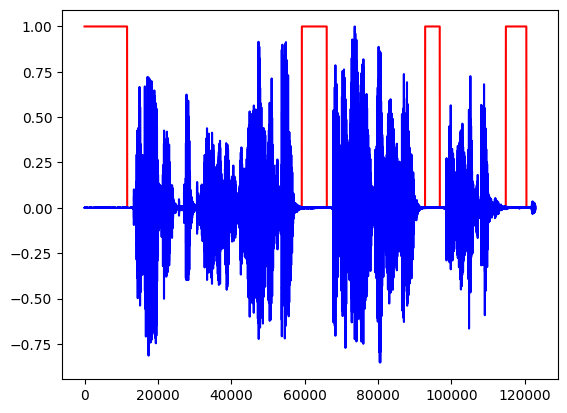

In [9]:
plot_these(d,s) # 

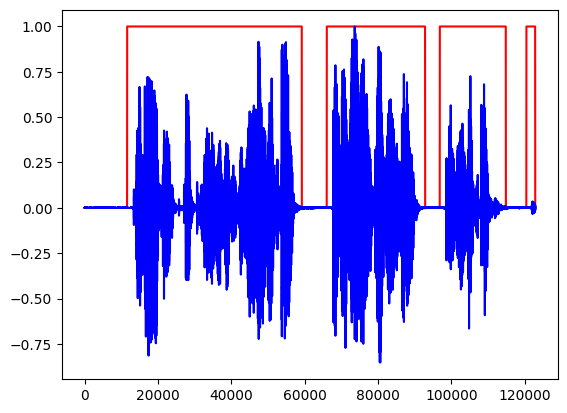

In [10]:
r_s, r_vad = get_speech(track) # r means reversed
r_d = deframe(r_vad, win_len, hop_len)
common_length = min(r_s.shape, r_d.shape)[0] # [0] cause it tuple
r_d = r_d[:common_length]
r_s = r_s[:common_length]
plot_these(r_d, r_s) # 

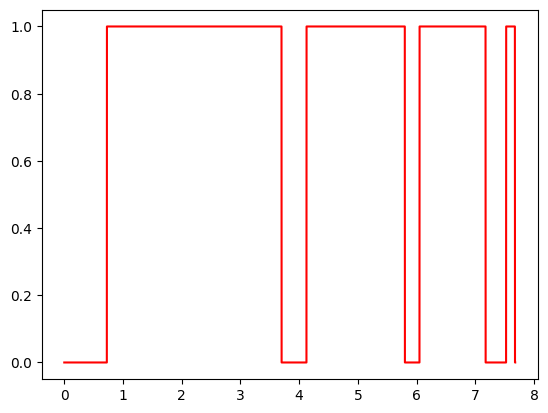

(122880,)

In [11]:
time_frame = getTimeFrame(fs, r_d) 
getPlot(time_frame, r_s, fs, r_d)
time_frame.shape

In [12]:
res = getLabel(r_d, time_frame, reversed_labels = False)
res

[{'speech': 0, 'start_time': 0.0, 'end_time': 0.724943399604489},
 {'speech': 1,
  'start_time': 0.7250059001131194,
  'end_time': 3.699967610413496},
 {'speech': 0,
  'start_time': 3.7000301109221265,
  'end_time': 4.124971069100497},
 {'speech': 1, 'start_time': 4.125033569609128, 'end_time': 5.799984700396325},
 {'speech': 0,
  'start_time': 5.800047200904955,
  'end_time': 6.0499867349180905},
 {'speech': 1, 'start_time': 6.05004923542672, 'end_time': 7.174995890266034},
 {'speech': 0, 'start_time': 7.175058390774664, 'end_time': 7.524998738596506},
 {'speech': 1, 'start_time': 7.525061239105136, 'end_time': 7.674999959309565},
 {'speech': 0, 'start_time': 7.675062459818195, 'end_time': 7.68}]

In [2]:
# labelingAudios ('/home/berik/workspace/Diploma/VoiceDetectionForKazakhSpeech/data/rawaudio/*.flac', saving = False,
#                 annotation_base_pth = '/home/berik/workspace/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/')

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

[{'speech': 0, 'start_time': 0.0, 'end_time': 1.6999479628278986}, {'speech': 1, 'start_time': 1.7000104632125757, 'end_time': 9.249994431801396}, {'speech': 0, 'start_time': 9.250056932186073, 'end_time': 10.1546875}]


**To json**

In [ ]:
labelingAudios (glob_paths['raw_audios'], saving = True, annotation_base_pth = paths['annotation'])

In [12]:
target = json.load(open(paths['test_audio_in_json'], 'r'))
print(json.dumps(target['speech_segments'][:3], indent=4))

[
    {
        "speech": 0,
        "start_time": 0.0,
        "end_time": 1.6999427273761605
    },
    {
        "speech": 1,
        "start_time": 1.7000052275683506,
        "end_time": 9.249965943929718
    },
    {
        "speech": 0,
        "start_time": 9.250028444121908,
        "end_time": 11.874974015910258
    },
    {
        "speech": 1,
        "start_time": 11.87503651610245,
        "end_time": 19.399997155587812
    },
    {
        "speech": 0,
        "start_time": 19.40005965578,
        "end_time": 20.299999923123995
    },
    {
        "speech": 1,
        "start_time": 20.300062423316184,
        "end_time": 20.325
    }
]


**To csv**

In [13]:
df = custom_get_df_from_json(paths['test_audio_in_json'])
df

,speech,start_time,end_time,utt_time,audio_id
0,0,0.000,1.700,1.700,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
1,1,1.700,9.250,7.550,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
2,0,9.250,11.875,2.625,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
3,1,11.875,19.400,7.525,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
4,0,19.400,20.300,0.900,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
5,1,20.300,20.325,0.025,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...


In [16]:
audio_id = paths['test_audio_in_json'].replace('.json', '.csv')
df.to_csv(audio_id, index=False)
print(audio_id)

C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/data/annotation/5ed8a1c0f3ea2_5ed8a1c0f3ea2dfsfsd.csv


Full .csv files

In [18]:
dataframes = get_consolidated_dfs(paths['annotation'])
dataframes

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 841.60it/s]


,speech,start_time,end_time,utt_time,audio_id
0,0,0.000,1.700,1.700,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
1,1,1.700,9.250,7.550,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
2,0,9.250,10.150,0.900,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
3,1,10.150,10.175,0.025,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
4,0,0.000,1.700,1.700,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
5,1,1.700,9.250,7.550,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
6,0,9.250,10.150,0.900,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
7,1,10.150,10.175,0.025,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
8,0,0.000,1.700,1.700,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...
9,1,1.700,9.250,7.550,C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/d...


In [19]:
audio_id = (paths['annotation'] + '0_COMBINED_DATAFS.csv')
dataframes.to_csv(audio_id, index=False)

#### Validate KS2 data

In [13]:
print(f"In data/Train .flac files count: {count_flac(glob(glob_paths['KS2_train']))}")
print(f"In data/Test .flac files count: {count_flac(glob(glob_paths['KS2_test']))}")
print(f"In data/Dev .flac files count: {count_flac(glob(glob_paths['KS2_dev']))}")
print(f"In data/ .flac files count: {count_flac(glob(glob_paths['KS2_raw']))}")

In data/Train .flac files count: 627824
In data/Test .flac files count: 9351
In data/Dev .flac files count: 8685
In data/ .flac files count: 645860


Нету ли дублирующий файлов директории

In [17]:
print(f"Duplicates in {glob_paths['KS2_train']}: {count_duplicates(glob(glob_paths['KS2_train']))}")
print(f"Duplicates in {glob_paths['KS2_dev']}: {count_duplicates(glob(glob_paths['KS2_dev']))}")
print(f"Duplicates in {glob_paths['KS2_test']}: {count_duplicates(glob(glob_paths['KS2_test']))}")
print(f"Duplicates in {glob_paths['KS2_raw']}: {count_duplicates(glob(glob_paths['KS2_raw']))}")

100%|██████████████████████████████████████████████████████████████████████| 627824/627824 [00:01<00:00, 436391.03it/s]


Duplicates in F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/**/*.flac: 26776


100%|██████████████████████████████████████████████████████████████████████████| 8685/8685 [00:00<00:00, 617279.76it/s]


Duplicates in F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/**/*.flac: 0


100%|██████████████████████████████████████████████████████████████████████████| 9351/9351 [00:00<00:00, 464175.07it/s]


Duplicates in F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/**/*.flac: 0


100%|██████████████████████████████████████████████████████████████████████| 645860/645860 [00:01<00:00, 429805.67it/s]

Duplicates in F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/**/**/*.flac: 28968


Имею ли папки `train test dev` одинаковые файлы

In [4]:
print(count_duplicates_between_folders(glob(glob_paths['KS2_raw'])))

100%|█████████████████████████████████████████████████████████████████████████████| 645860/645860 [00:02<00:00, 262639.89it/s]

0


Проверить что файлы некоторые файлы содержат удвоенное расширение `.flac.flac`

In [5]:
audios_with_double_ext = getDoubleExt(glob(glob_paths['KS2_raw']))
if audios_with_double_ext:
    print(f"Количество файлов с удвоенным расширением: {len(audios_with_double_ext)}")
    print(f'Пример: {audios_with_double_ext[0]}')
else:
    print("Файлы с удвоенным расширением не найдены.")

Количество файлов с удвоенным расширением: 5044
Пример: F:/ISSAI_KSC2_unpacked/ISSAI_KSC2\Dev\tv_news\415465.flac.flac


**5044**. Проверить существует ли аудио с одинаковыми именами и .flac.flac и .flac.

In [3]:
print(count_double_ext_matches(glob(glob_paths['KS2_raw']), getDoubleExt(glob(glob_paths['KS2_raw']))))

100%|█████████████████████████████████████████████████████████████████████████████| 645860/645860 [00:01<00:00, 475165.99it/s]

(0, [])


Все файлы с расширение .flac.flac не имеют файлы с расширение файлы .flac, поэтому можно **переменовать**.

In [ ]:
rename_double_ext_audios (getDoubleExt(glob(glob_paths['KS2_raw'])))

In [4]:
audios_with_double_ext_after = getDoubleExt(glob(glob_paths['KS2_raw']))
if audios_with_double_ext_after:
    print(f"Количество файлов с удвоенным расширением: {len(audios_with_double_ext_after)}")
    print(f'Пример: {audios_with_double_ext_after[0]}')
else:
    print("Файлы с удвоенным расширением не найдены.")

Файлы с удвоенным расширением не найдены.


#### LABELING KS2

**To Json**

In [3]:
labelingAudios(glob_paths['KS2_raw'], saving = True, annotation_base_pth = paths['annotation'])

100%|███████████████████████████████████████████████████████████████████| 645860/645860 [00:00<00:00, 663381.07it/s]


In [6]:
assert get_counts_with_p(glob(glob_paths['KS2_raw']), 'flac')  == get_counts_with_p(glob(glob_paths['KS2_jsons']), 'json')

645860


**To Csv**

Разделил на три отдельных: `train_df`, `test_df`, `dev_df`. Т.к. побоялся что все в один файл csv не влезет.

_Dev_

In [3]:
dataframes_dev = get_consolidated_dfs(glob(glob_paths['KS2_json_dev']), paths['KS2'], each_saving = True)

100%|██████████████████████████████████████████████████████████████████████████| 8685/8685 [00:25<00:00, 338.79it/s]


In [4]:
dataframes_dev.head()

,speech,start_time,end_time,utt_time,audio_id
0,0,0.000,0.725,0.725,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsou...
1,1,0.725,3.700,2.975,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsou...
2,0,3.700,4.125,0.425,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsou...
3,1,4.125,5.800,1.675,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsou...
4,0,5.800,6.050,0.250,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsou...


In [5]:
dataframes_dev.to_csv((paths['KS_DATA_INFO'] + '0_COMBINED_DATAFS_DEV.csv'), index=False)

In [6]:
speech_dev, non_speech_dev = process_dataframe(dataframes_dev)

Count of intervals:  48540
Total time of speech (s):  44423.37500000001
Total time of non-speech (s):  8882.034
Total time (s) in dataset:  53305.40900000001


_Test_

In [7]:
dataframes_test = get_consolidated_dfs(glob(glob_paths['KS2_json_test']), paths['KS2'], each_saving = True)

100%|██████████████████████████████████████████████████████████████████████████| 9351/9351 [00:27<00:00, 335.81it/s]


In [8]:
dataframes_test.head()

,speech,start_time,end_time,utt_time,audio_id
0,0,0.00,1.350,1.350,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/crowdso...
1,1,1.35,6.100,4.750,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/crowdso...
2,0,6.10,6.500,0.400,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/crowdso...
3,1,6.50,7.800,1.300,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/crowdso...
4,0,7.80,8.789,0.989,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Test/crowdso...


In [9]:
dataframes_test.to_csv((paths['KS_DATA_INFO'] + '0_COMBINED_DATAFS_TEST.csv'), index=False)

In [10]:
speech_test, non_speech_test = process_dataframe(dataframes_test)

Count of intervals:  54405
Total time of speech (s):  47931.5
Total time of non-speech (s):  9497.116
Total time (s) in dataset:  57428.616


_Train_

In [11]:
dataframes_train = get_consolidated_dfs(glob(glob_paths['KS2_json_train']), paths['KS2'], each_saving = True)

100%|██████████████████████████████████████████████████████████████████████| 627824/627824 [33:55<00:00, 308.44it/s]


In [12]:
dataframes_train.head()

,speech,start_time,end_time,utt_time,audio_id
0,0,0.000,1.150,1.150,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/crowds...
1,1,1.150,1.975,0.825,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/crowds...
2,0,1.975,2.000,0.025,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/crowds...
3,1,2.000,2.975,0.975,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/crowds...
4,0,2.975,3.250,0.275,F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Train/crowds...


In [13]:
dataframes_train.to_csv((paths['KS_DATA_INFO'] + '0_COMBINED_DATAFS_TRAIN.csv'), index=False)

In [14]:
speech_train, non_speech_train = process_dataframe(dataframes_train)

Count of intervals:  3646219
Total time of speech (s):  3542639.8999999994
Total time of non-speech (s):  645583.0969999995
Total time (s) in dataset:  4188222.996999999


In [15]:
print("Total time of speech (s): ", speech_dev + speech_test + speech_train)
print("Total time of non speech (s): ", non_speech_dev + non_speech_test + non_speech_train)
print("Total time (s): ", (speech_dev + non_speech_dev) + (speech_test + non_speech_test) + (speech_train + non_speech_train))

Total time of speech (s):  3634994.7749999994
Total time of non speech (s):  663962.2469999995
Total time (s):  4298957.021999999


In [16]:
combined_dataframe = pd.concat([dataframes_train, dataframes_test, dataframes_dev], ignore_index=True)
combined_dataframe.to_csv((paths['KS_DATA_INFO'] + '0_FULL_DATAFRAMES.csv'), index=False)

#### Non-speech noise samples creation

**Conclusion**

[ENG]
Dataset is **not balanced**. The `speechs` is almost **`5.5`** times larger than `non speechs`. To balance the dataset, it was decided to extract segments without speech and then **add** them to the audio recordings. Some samples are not suitable for training the neural network because they contain only the single class 1. Therefore, it is necessary to remove all such examples from the dataset. Fortunately, `total samples`: `645 860` is large enough to do not add them.

[RUS]
Как видно из `print` набор данных **не сбалансирован**, `speechs` почти в **`5.5`** больше чем `non speechs`. Поэтому что бы сбалансировать датасет было решено - извлечь сегменты где нету речи, затем **добавить** их в аудиозаписи. Так же, некоторые примеры (сэмплы) не подходят для обучение нейросети, т.к. содержат только едиственный класс 1. Поэтому в этих целях требуется убрать все такие пример из выборки. К счастью `размер выборки` `645 860` большой поэтому мы можем позволить их не добавлять.    

In [4]:
# On full dataset
single_samples_full_ds = getSamplesWithOneClasses(glob(glob_paths['KS2_jsons']), paths['KS2'])

100%|█████████████████████████████████████████████████████████████████████| 645860/645860 [08:09<00:00, 1318.32it/s]


In [35]:
print(single_samples_full_ds[:1])

['C:/Users/b.smadiarov/Diploma/VD-KazakhSpeech/data/annotation/Json/Dev/podcasts/07_00_218.json']


In [7]:
print("Count of samples doesnt contain zeroes in targets", len(single_samples_full_ds))

Count of samples doesnt contain zeroes in targets 137


In [9]:
print("Time duration of samples doesnt contain zeroes", get_total_time_duration(mapper_from_json_to_flac(single_samples_full_ds, paths['KS2'])))

100%|██████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 15351.85it/s]

Time duration of samples doesnt contain zeroes 334.8


[ENG] 
**To balance dataset**: `3 634 994 - 663 962 - 335` = `2 970 697` (s) ~ `825` (h)

[RUS]
**Что бы сбалансировать датасет нужно**: `3 634 994 - 663 962 - 335` = `2 970 697` (c) ~ `825` (ч)

**Extract non-speech signals**

In [10]:
import random 
seeed = 13 # 42
random.seed(seeed)
tracklist = random.choices(glob(glob_paths['KS2_raw']), k = 5200000)
custom_create_noise_samples(tracklist, 'F:/ISSAI_KSC2_unpacked/noises/', seeed, total_duration=2995125)

100%|███████████████████████████████████████████████████████████████| 5200000/5200000 [00:00<00:00, 12208790.06it/s]


In [11]:
noise_files = glob('F:/ISSAI_KSC2_unpacked/noises/*.flac')
noise_files[0:5]

['F:/ISSAI_KSC2_unpacked/noises\\noise_01_00_004_id1124965_sd13.flac',
 'F:/ISSAI_KSC2_unpacked/noises\\noise_01_00_004_id1200515_sd13.flac',
 'F:/ISSAI_KSC2_unpacked/noises\\noise_01_00_004_id1296581.flac',
 'F:/ISSAI_KSC2_unpacked/noises\\noise_01_00_004_id1508308.flac',
 'F:/ISSAI_KSC2_unpacked/noises\\noise_01_00_004_id1621985.flac']

In [12]:
get_total_time_duration(noise_files)

100%|███████████████████████████████████████████████████████████████████| 1815079/1815079 [13:30<00:00, 2240.24it/s]


2955605.174996745

#### Add non-speech samples to existing signals

In [13]:
all_jsons = glob(glob_paths['KS2_jsons'])
ones_samples = set(mapper_from_json_to_flac(getSamplesWithOneClasses(all_jsons, paths['KS2']), paths['KS2']))

100%|██████████████████████████████████████████████████████████████████████| 645860/645860 [19:29<00:00, 552.08it/s]


In [14]:
tracklist = glob(glob_paths['KS2_raw'])
tracklist_len_with_right_targes = sum(1 for t in tracklist if t.replace('\\', '/') not in ones_samples)

In [ ]:
assert len(ones_samples) + tracklist_len_with_right_targes == len(tracklist)

In [ ]:
tracklist = glob(glob_paths['KS2_raw'])
noise_files = glob(glob_paths['noises'])
coeff = round(len(noise_files) / tracklist_len_with_right_targes)
coeff
# coeff = 3

In [4]:
def ___add_noise_to_track(audio_path, json_sets, csv_sets, raw_base_path, path_to_save, noise_files, noise_file_idx, coeff=3):
    if noise_file_idx > len(noise_files):
            noise_file_idx = 0
    signal, sr = librosa.load(audio_path, sr=16000)
    name_with_extension = os.path.basename(audio_path)
    postfix = re.sub(r'.*ISSAI_KSC2', '', audio_path)
    json_file = json_sets + postfix.replace('.flac', '.json')
    df = custom_get_df_from_json(json_file, raw_base_path)
    time_indices = list(df[df.speech == 0].index)
    # ones = list(df[df.speech == 1].index) # addentional protection 
    
    # sample doesn't contains zeroes in 
    if not time_indices: 
        return None, None, noise_file_idx
    
    time_idx = sorted(random.choices(time_indices, k=coeff))
    for idx in time_idx:
        if noise_file_idx > len(noise_files):
            noise_file_idx = 0
        noise, sr = librosa.load(noise_files[noise_file_idx], sr=16000)
        noise_len = len(noise) / sr
        noise = noise - np.mean(noise)
        time_sample = int(df.iloc[idx].start_time * sr)
        signal = np.concatenate([signal[:time_sample], noise, signal[time_sample:]])
        noise_file_idx += 1
        # modify df
        df.loc[df.index > idx, 'start_time'] += noise_len
        df.loc[df.index == idx, 'utt_time'] += noise_len
        df.loc[df.index >= idx, 'end_time'] += noise_len

    df['audio_id'] = path_to_save + name_with_extension
    return signal, df, noise_file_idx

In [9]:
# Process each signal and save CSV annotations
noise_file_idx = 0

for t in tqdm(tracklist):
    if noise_file_idx > len(noise_files):
        noise_file_idx = 0
    
    t = t.replace('\\', '/')
    audio_name = re.sub(r'.*ISSAI_KSC2/', '', t).replace('/', '-') # Example: 'Train-tv_show-5ed8a1c0f3ea2.flac'
    signal, df, curr_file_idx = ___add_noise_to_track(t, paths['KS2_annotation_json'], paths['KS2_annotation_csv'], 
                                    paths['KS2'], paths['augmented_data'], noise_files, noise_file_idx, coeff = coeff)
    
    if curr_file_idx > len(noise_files):
        noise_file_idx = 0 
    else:
        noise_file_idx = curr_file_idx
        
    if signal is not None and df is not None:
        sf.write(f"{paths['augmented_data']}{audio_name}", signal, samplerate=16000)
        df.to_csv(f"{paths['augmented_data']}{audio_name.replace('.flac', '.csv')}", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40753/40753 [12:53<00:00, 52.67it/s]


In [10]:
# Get full dataset DF
annotations = glob(glob_paths['augmented_csv'])
all_dfs = []
for csv in tqdm(annotations):
    df = pd.read_csv(csv)
    all_dfs.append(df)

df = pd.concat(all_dfs).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 645723/645723 [08:27<00:00, 1271.42it/s]


In [ ]:
print("Total time of speech (s): ", df[df['speech']==1].utt_time.sum())
print("Total time of non speech (s): ", df[df['speech']==0].utt_time.sum())

[ENG] We can see that we have (approximatively) **balanced** our dataset.

[RUS] Мы можем увидеть что датасет (почти) **сбалансирован**.

#### Annotation alignement verification

**Temporal domain**

In [27]:
import torchaudio

In [28]:
tracklist = glob('F:/ISSAI_KSC2_unpacked/temp_vad/*.flac')

In [29]:
t = random.choice(tracklist)
print('name of audio', t)
signal, sr = librosa.load(t, sr=16000)

name of audio F:/ISSAI_KSC2_unpacked/temp_vad\Dev-parliament-mazhilis_02_079.flac


In [32]:
ipd.display(ipd.Audio(signal, rate=sr, autoplay=False))

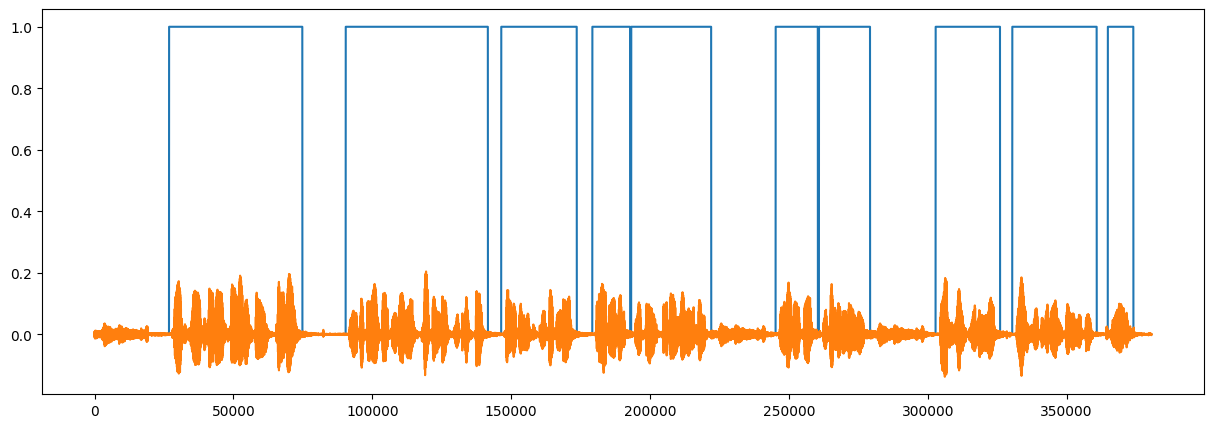

In [33]:
df = pd.read_csv(t.replace('.flac', '.csv'))
get_gt_plot_waveform(signal, df)

**Frequency domain**

In [34]:
melspec = torchaudio.transforms.MelSpectrogram(n_fft=1024, hop_length=512, n_mels=60)

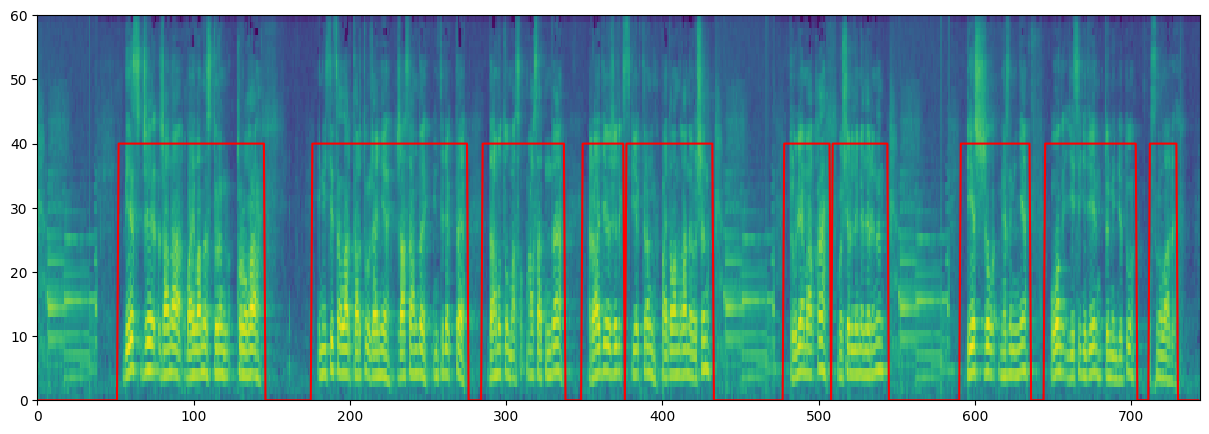

In [35]:
get_plot_spectro(t, melspec, hop_length=512)

[ENG] Looks **OK**, we can now begin the training pipeline

[RUS] Все **хорошо**, можно начинать этап обучения